In [1]:
import scipy
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csgraph
from scipy.sparse import issparse
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances as pair
from sklearn.metrics import adjusted_rand_score as ari_score
import networkx as nx
import matplotlib.pyplot as plt
import scanpy as sc

In [251]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
from sklearn.decomposition import NMF

In [8]:
import h5py
import numpy as np
import anndata as ad
import pandas as pd

In [252]:
def refine(sample_id, pred, dis):
    refined_pred = []
    pred = pd.DataFrame({"pred": pred}, index=sample_id)
    dis_df = pd.DataFrame(dis, index=sample_id, columns=sample_id)
    global num_nbs
    
    num_nbs = 6
        
    for i in range(len(sample_id)):
        index = sample_id[i]
        dis_tmp = dis_df.loc[index, :].sort_values()
        nbs = dis_tmp[0:num_nbs + 1]
        nbs_pred = pred.loc[nbs.index, "pred"]
        self_pred = pred.loc[index, "pred"]
        v_c = nbs_pred.value_counts()
        if (v_c.loc[self_pred] < num_nbs / 2) and (np.max(v_c) > num_nbs / 2):
            refined_pred.append(v_c.idxmax())
        else:
            refined_pred.append(self_pred)
    return refined_pred

## PCA

In [253]:
def Run_GPCA(adata, location=None, n_components=50, _lambda=0.5, save_reconstruction=False):

    global graphL
    Expr = adata.X
    if issparse(Expr):
        Expr = Expr.todense()
    
    n_neighbors = 6
    
    graph = kneighbors_graph(np.asarray(location), int(n_neighbors), metric='euclidean',
                                 metric_params={}, include_self=False)
    graph = 0.5 * (graph + graph.T)
        
    graphL = csgraph.laplacian(graph, normed=False)

    G = scipy.sparse.eye(adata.shape[0]) + _lambda * graphL
    if issparse(G):
        Ginv = np.array(np.linalg.inv(G.todense()))
    else:
        Ginv = np.array(np.linalg.inv(G))
    C = np.dot(np.dot(Expr.T, Ginv), Expr)
    lambdas, W = np.linalg.eigh(C)
    W = W[:, ::-1]
    W = W[:, :n_components]
    Z = np.dot(np.dot(Ginv, Expr), W)
    if save_reconstruction:
        adata.layers["GraphPCA_ReX"] = np.dot(Z,W.T)
    return Z, W

## NMF

In [254]:
def Run_GNMF(adata, location=None, n_components=50, _lambda=0.5, save_reconstruction=False, **nmf_kwargs):

    global graphL
    Expr = adata.X
    if issparse(Expr):
        Expr = Expr.todense()
    
    n_neighbors = 6
    
    graph = kneighbors_graph(np.asarray(location), int(n_neighbors), metric='euclidean',
                                 metric_params={}, include_self=False)
    graph = 0.5 * (graph + graph.T)
    

    graphL = csgraph.laplacian(graph, normed=False)
    
    G = scipy.sparse.eye(adata.shape[0]) + _lambda * graphL
    Ginv = np.array(np.linalg.inv(G.todense()) if issparse(G) else np.linalg.inv(G))
    
    nmf = NMF(n_components=n_components, random_state=42, **nmf_kwargs)
    Z = nmf.fit_transform(np.dot(Ginv, Expr))
    W = nmf.components_.T
    
    if save_reconstruction:
        adata.layers["GraphNMF_ReX"] = np.dot(Z, W.T)

    return Z, W

## Analysis

In [34]:
import time

In [255]:
adata = sc.read_h5ad("brain_151673.h5ad")
print(adata)

AnnData object with n_obs × n_vars = 3611 × 3187
    obs: 'sample_id', 'in_tissue', 'array_row', 'array_col', 'ground_truth', 'cell_count'
    var: 'gene_name'
    obsm: 'spatial'


In [256]:
start_time = time.time()

Run_GPCA(adata, location=adata.obsm['spatial'], n_components=50,
         _lambda=0.5, save_reconstruction=False)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 8.31712007522583 seconds


In [257]:
start_time = time.time()

Run_GNMF(adata, location=adata.obsm['spatial'], n_components=50,
         _lambda=0.5, save_reconstruction=False)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 8.157243251800537 seconds


In [258]:
start_time = time.time()

#init='nndsvda'
Run_GNMF(adata, location=adata.obsm['spatial'], n_components=50, _lambda=0.5,
         save_reconstruction=False, max_iter = 2000, init = 'nndsvda', solver="mu")

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 7.311164855957031 seconds


In [259]:
start_time = time.time()

#init='nndsvdar'
Run_GNMF(adata, location=adata.obsm['spatial'], n_components=50, _lambda=0.5,
         save_reconstruction=False, max_iter = 2000, init = 'nndsvdar', solver="mu")

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 25.148677110671997 seconds


### Make a backup of adata

In [260]:
adata_backup = adata.copy()

In [261]:
adata_2 = adata_backup.copy()

In [263]:
adata_2

AnnData object with n_obs × n_vars = 3611 × 3187
    obs: 'sample_id', 'in_tissue', 'array_row', 'array_col', 'ground_truth', 'cell_count'
    var: 'gene_name'
    obsm: 'spatial'

In [264]:
sc.experimental.pp.normalize_pearson_residuals(adata_2)

In [265]:
sc.pp.scale(adata_2, zero_center=True, max_value=None)

In [267]:
np.unique(adata_2.obs.ground_truth)

array(['Layer1', 'Layer2', 'Layer3', 'Layer4', 'Layer5', 'Layer6', 'WM'],
      dtype=object)

In [268]:
x_array = adata_2.obs.array_row.tolist()
y_array = adata_2.obs.array_col.tolist()
location = np.array([x_array, y_array]).T.astype(np.float32)

In [269]:
Z,W = Run_GPCA(adata_2, location=location)

In [270]:
estimator = KMeans(n_clusters=7)
res = estimator.fit(Z)

lable_pred=res.labels_
adata_2.obs["GPCA_pred"]= lable_pred
adata_2.obs["GPCA_pred"] = adata_2.obs["GPCA_pred"].astype('category')

refined_pred=refine(sample_id=adata_2.obs.index.tolist(), 
                    pred=adata_2.obs["GPCA_pred"].tolist(), dis= pair(location))

adata_2.obs["GPCA_pred"]= refined_pred
adata_2.obs["GPCA_pred"] = adata_2.obs["GPCA_pred"].astype('category')

print(ari_score(adata_2.obs.GPCA_pred,adata_2.obs.ground_truth))

0.5372014434193617


In [271]:
#adata_2.write_h5ad("adata_2.h5ad")

adata_2

AnnData object with n_obs × n_vars = 3611 × 3187
    obs: 'sample_id', 'in_tissue', 'array_row', 'array_col', 'ground_truth', 'cell_count', 'GPCA_pred'
    var: 'gene_name', 'mean', 'std'
    uns: 'pearson_residuals_normalization'
    obsm: 'spatial'

In [272]:
spatial_coords = adata_2.obsm["spatial"]

adata_2.obs["x_coord"] = spatial_coords[:, 0]
adata_2.obs["y_coord"] = spatial_coords[:, 1]

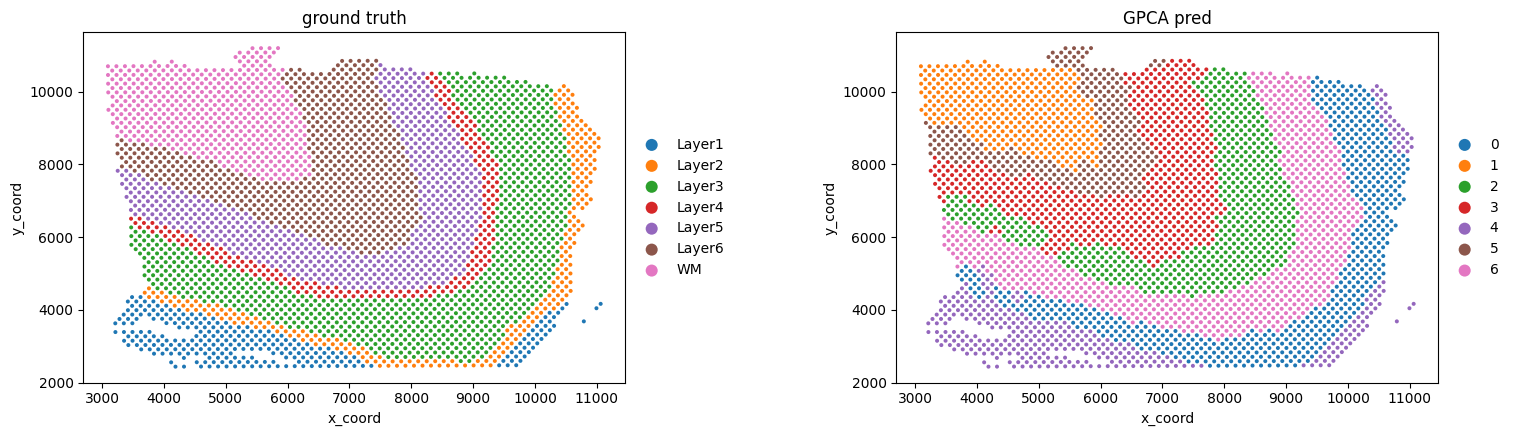

In [273]:
sc.pl.scatter(adata_2, x="x_coord", y="y_coord", color=["ground_truth", "GPCA_pred"])

## NMF and PCA comparision

## PCA with sparse input

In [274]:
adata_3 = adata_backup.copy()

In [275]:
sc.pp.scale(adata_3, zero_center=True, max_value=None)

In [276]:
X_new = adata_3.T.X - adata_3.T.X.min(axis=1).reshape(-1, 1)
adata_3.X = X_new.T

In [277]:
x_array = adata_3.obs.array_row.tolist()
y_array = adata_3.obs.array_col.tolist()
location = np.array([x_array, y_array]).T.astype(np.float32)

In [278]:
adata_3

AnnData object with n_obs × n_vars = 3611 × 3187
    obs: 'sample_id', 'in_tissue', 'array_row', 'array_col', 'ground_truth', 'cell_count'
    var: 'gene_name', 'mean', 'std'
    obsm: 'spatial'

In [279]:
Z,W = Run_GPCA(adata_3, location=location)

In [281]:
estimator = KMeans(n_clusters=7)
res = estimator.fit(Z)

lable_pred=res.labels_
adata_3.obs["GPCA_pred"]= lable_pred
adata_3.obs["GPCA_pred"] = adata_3.obs["GPCA_pred"].astype('category')

refined_pred=refine(sample_id=adata_3.obs.index.tolist(), 
                    pred=adata_3.obs["GPCA_pred"].tolist(), dis= pair(location))

adata_3.obs["GPCA_pred"]= refined_pred
adata_3.obs["GPCA_pred"] = adata_3.obs["GPCA_pred"].astype('category')

print(ari_score(adata_3.obs.GPCA_pred,adata_3.obs.ground_truth))

0.20542124335203715


In [283]:
spatial_coords = adata_3.obsm["spatial"]

adata_3.obs["x_coord"] = spatial_coords[:, 0]
adata_3.obs["y_coord"] = spatial_coords[:, 1]

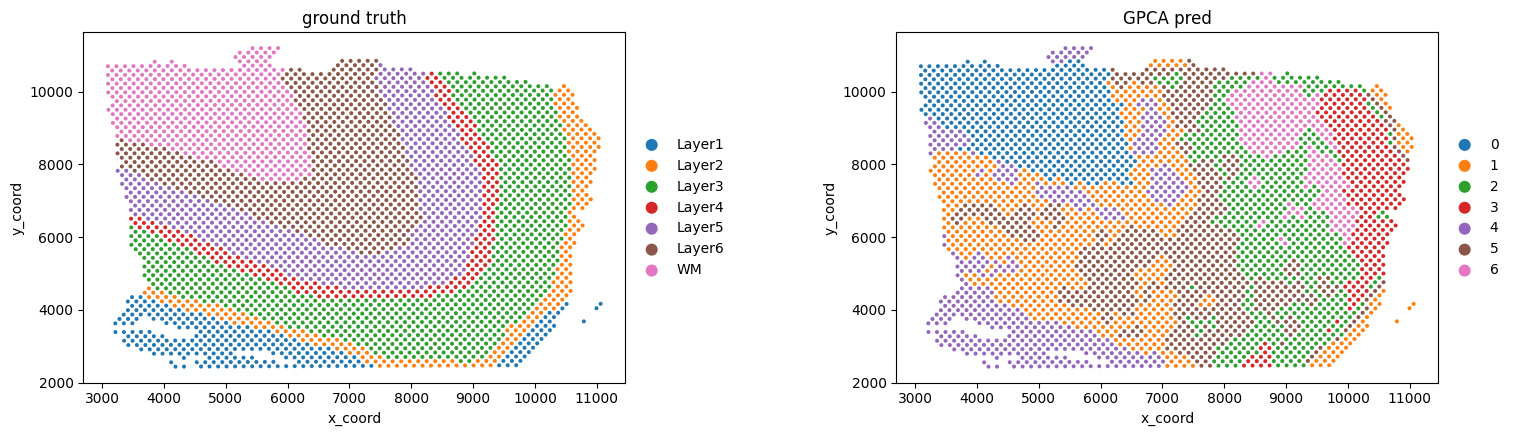

In [284]:
sc.pl.scatter(adata_3, x="x_coord", y="y_coord", color=["ground_truth", "GPCA_pred"])

In [328]:
adata_3.obs["GNMF_pred"] = adata_3.obs["GPCA_pred"]

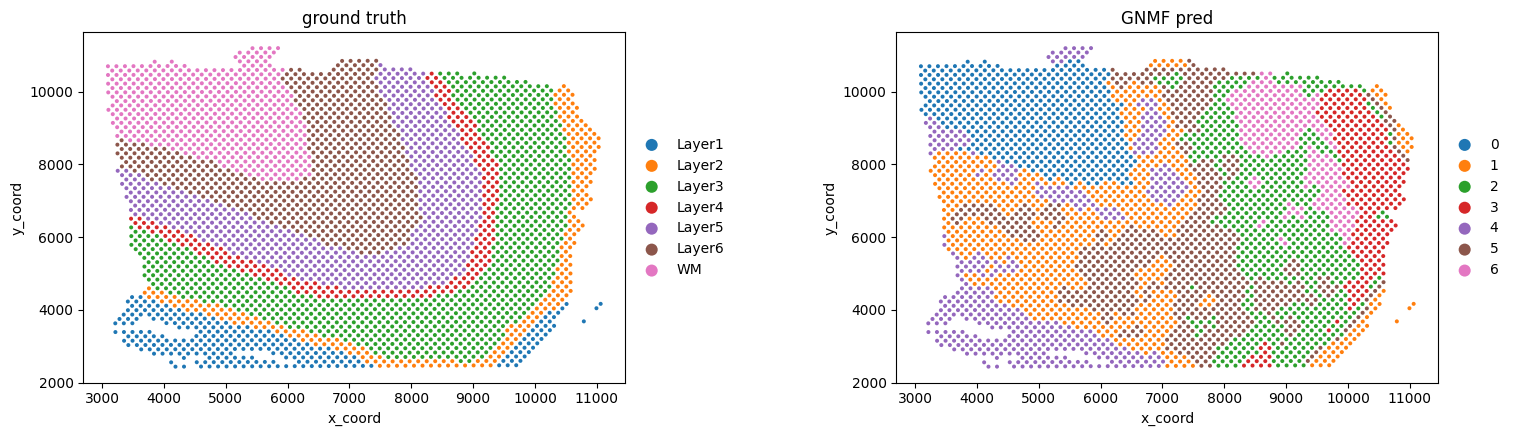

In [329]:
sc.pl.scatter(adata_3, x="x_coord", y="y_coord", color=["ground_truth", "GNMF_pred"])

## NMF with sparse input

In [285]:
adata_4 = adata_backup.copy()

In [286]:
sc.pp.scale(adata_4, zero_center=True, max_value=None)

In [287]:
X_new = adata_4.T.X - adata_4.T.X.min(axis=1).reshape(-1, 1)
adata_4.X = X_new.T

In [288]:
x_array = adata_4.obs.array_row.tolist()
y_array = adata_4.obs.array_col.tolist()
location = np.array([x_array, y_array]).T.astype(np.float32)

In [290]:
Z,W = Run_GNMF(adata_4, location=location, max_iter = 10000, init = 'nndsvda', solver="mu")

In [291]:
estimator = KMeans(n_clusters=7)
res = estimator.fit(Z)

lable_pred=res.labels_
adata_4.obs["GPCA_pred"]= lable_pred
adata_4.obs["GPCA_pred"] = adata_4.obs["GPCA_pred"].astype('category')

refined_pred=refine(sample_id=adata_4.obs.index.tolist(), 
                    pred=adata_4.obs["GPCA_pred"].tolist(), dis= pair(location))

adata_4.obs["GPCA_pred"]= refined_pred
adata_4.obs["GPCA_pred"] = adata_4.obs["GPCA_pred"].astype('category')

print(ari_score(adata_4.obs.GPCA_pred,adata_4.obs.ground_truth))

0.34284622578903073


In [292]:
spatial_coords = adata_4.obsm["spatial"]

adata_4.obs["x_coord"] = spatial_coords[:, 0]
adata_4.obs["y_coord"] = spatial_coords[:, 1]

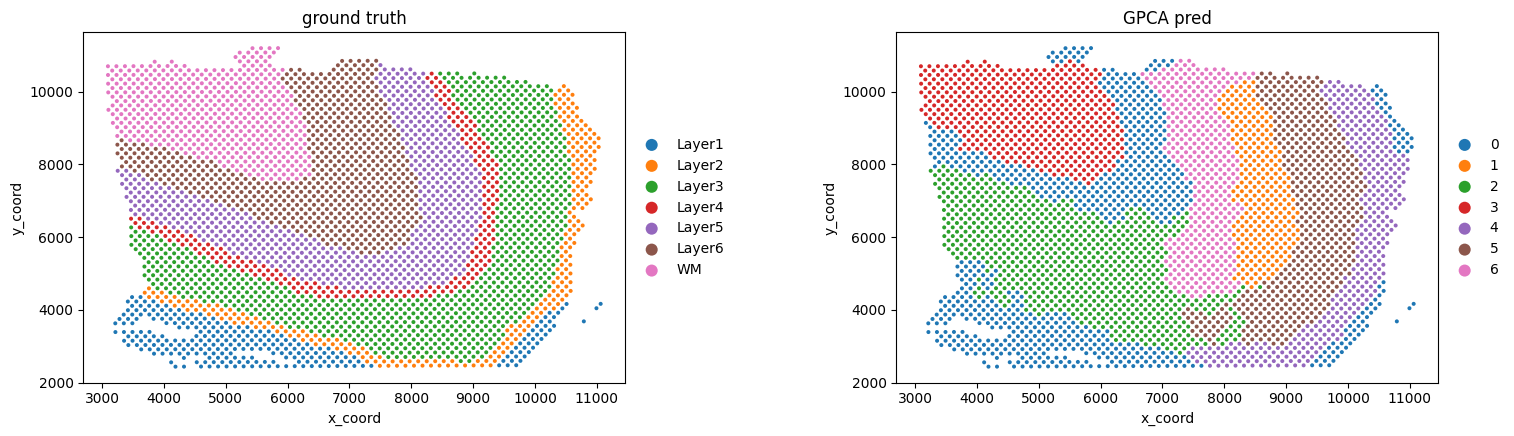

In [293]:
sc.pl.scatter(adata_4, x="x_coord", y="y_coord", color=["ground_truth", "GPCA_pred"])

In [330]:
adata_4.obs["GNMF_pred"] = adata_4.obs["GPCA_pred"]

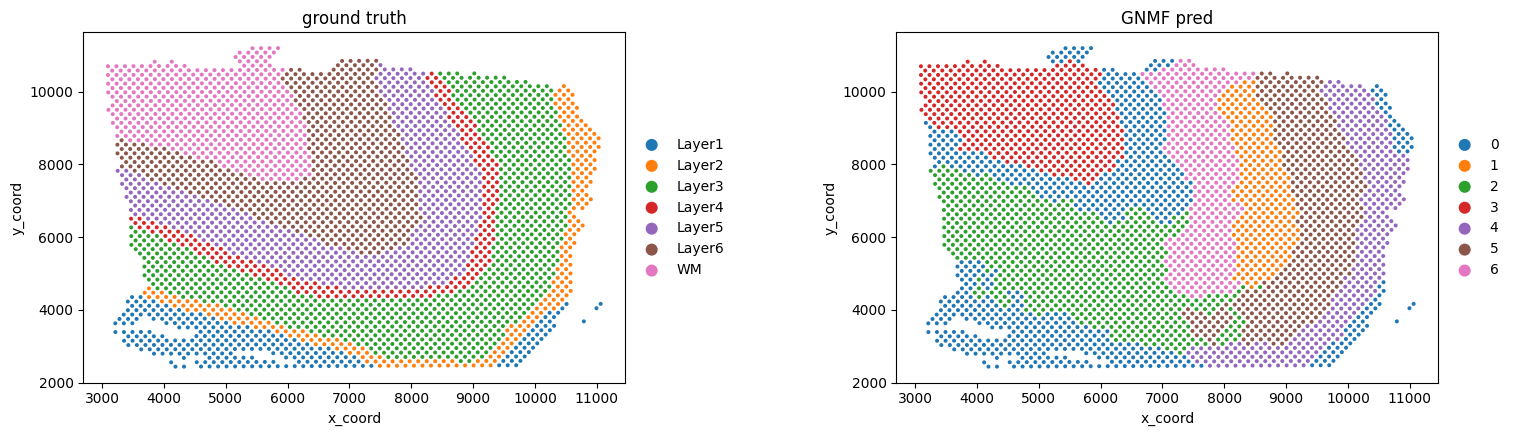

In [351]:
sc.pl.scatter(adata_4, x="x_coord", y="y_coord", color=["ground_truth", "GNMF_pred"])

# Sparse NMF with Pearson Residuals

In [370]:
adata_5 = adata_backup.copy()

In [371]:
sc.experimental.pp.normalize_pearson_residuals(adata_5)

In [372]:
X_new = adata_5.T.X - adata_5.T.X.min(axis=1).reshape(-1, 1)
adata_5.X = X_new.T

In [373]:
sc.pp.scale(adata_5, zero_center=True, max_value=None)

In [374]:
X_new = adata_5.T.X - adata_5.T.X.min(axis=1).reshape(-1, 1)
adata_5.X = X_new.T

In [375]:
x_array = adata_5.obs.array_row.tolist()
y_array = adata_5.obs.array_col.tolist()
location = np.array([x_array, y_array]).T.astype(np.float32)

In [376]:
Z,W = Run_GNMF(adata_5, location=location, max_iter = 10000, init = 'nndsvda', solver="mu")

In [377]:
estimator = KMeans(n_clusters=7)
res = estimator.fit(Z)

lable_pred=res.labels_
adata_5.obs["GPCA_pred"]= lable_pred
adata_5.obs["GPCA_pred"] = adata_5.obs["GPCA_pred"].astype('category')

refined_pred=refine(sample_id=adata_5.obs.index.tolist(), 
                    pred=adata_5.obs["GPCA_pred"].tolist(), dis= pair(location))

adata_5.obs["GPCA_pred"]= refined_pred
adata_5.obs["GPCA_pred"] = adata_5.obs["GPCA_pred"].astype('category')

print(ari_score(adata_5.obs.GPCA_pred,adata_5.obs.ground_truth))

0.47274970179446907


In [378]:
spatial_coords = adata_5.obsm["spatial"]

adata_5.obs["x_coord"] = spatial_coords[:, 0]
adata_5.obs["y_coord"] = spatial_coords[:, 1]

In [379]:
adata_5.obs["GNMF_pred"] = adata_5.obs["GPCA_pred"]

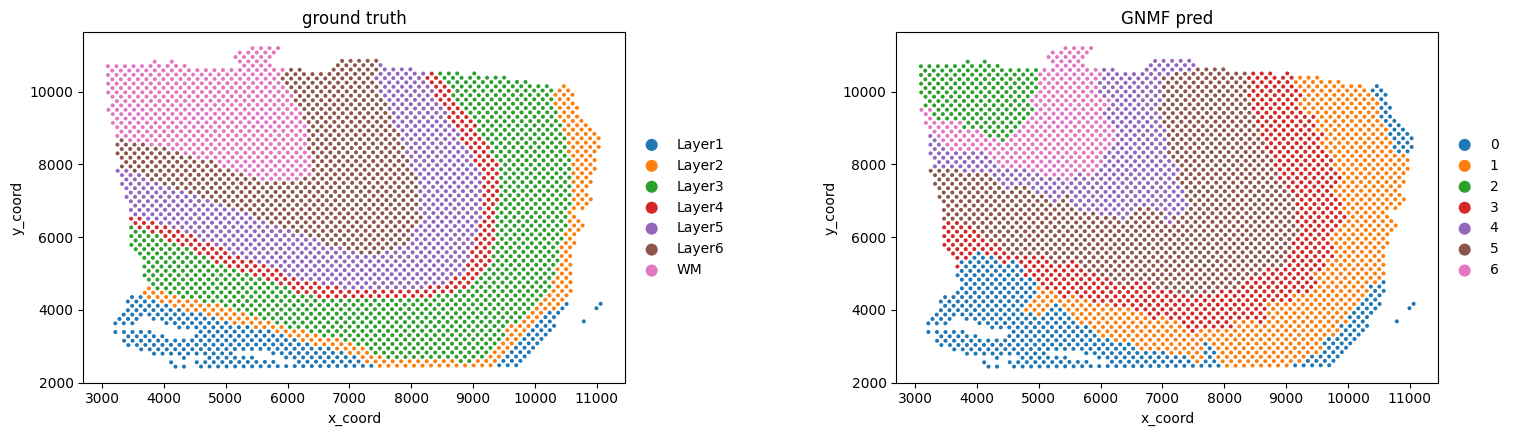

In [380]:
sc.pl.scatter(adata_5, x="x_coord", y="y_coord", color=["ground_truth", "GNMF_pred"])

In [346]:
Z,W = Run_GNMF(adata_5, location=location, max_iter = 10000, init = 'nndsvdar', solver="mu")

In [318]:
estimator = KMeans(n_clusters=7)
res = estimator.fit(Z)

lable_pred=res.labels_
adata_5.obs["GPCA_pred"]= lable_pred
adata_5.obs["GPCA_pred"] = adata_5.obs["GPCA_pred"].astype('category')

refined_pred=refine(sample_id=adata_5.obs.index.tolist(), 
                    pred=adata_5.obs["GPCA_pred"].tolist(), dis= pair(location))

adata_5.obs["GPCA_pred"]= refined_pred
adata_5.obs["GPCA_pred"] = adata_5.obs["GPCA_pred"].astype('category')

print(ari_score(adata_5.obs.GPCA_pred,adata_5.obs.ground_truth))

0.5825309058028609


In [349]:
spatial_coords = adata_5.obsm["spatial"]

adata_5.obs["x_coord"] = spatial_coords[:, 0]
adata_5.obs["y_coord"] = spatial_coords[:, 1]

In [353]:
adata_5.obs["GNMF_pred"] = adata_5.obs["GPCA_pred"]

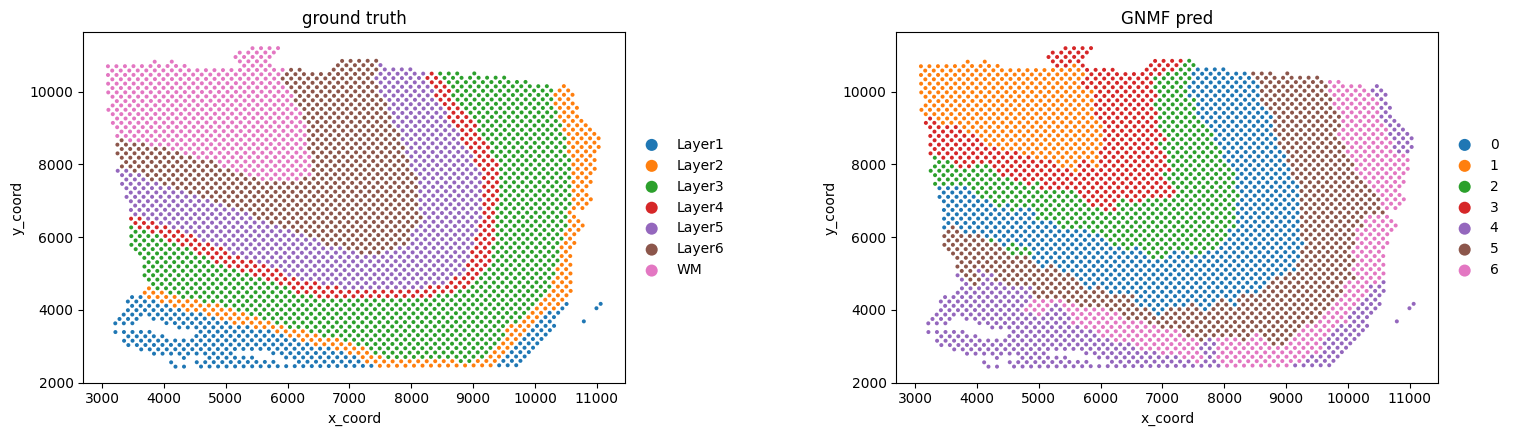

In [354]:
sc.pl.scatter(adata_5, x="x_coord", y="y_coord", color=["ground_truth", "GNMF_pred"])

In [326]:
!which python3

/Users/mohith/.pyenv/versions/3.13.0/bin/python3
